<a href="https://colab.research.google.com/github/therokitoki/AA2_TP_Alsop-Hachen-Nemeth/blob/main/ejercicio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico AAII

Alumnos: Agustín Alsop, Rocío Hachen, Ulises Nemeth

# Ejercicio 3

## Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Dataset:
https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

> - buildings
> - forest
> - glacier
> - mountain
> - sea
> - street

Las imágenes están divididas en tres conjuntos:
- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.


Los modelos a diseñar son:
- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad.
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning).


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


# Librerias

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

# Para trabajar con Redes Neuronales
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout, Dense, Conv2D, Activation, MaxPooling2D, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Descarga de dataset

In [ ]:
!gdown 1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=ad8e6164-e4a7-48c2-85e8-ce7707ec65ef
To: /content/AA2_TP_Alsop-Hachen-Nemeth/TP1-3-natural-scenes.zip
100% 363M/363M [00:07<00:00, 49.8MB/s]


In [ ]:
zip_path = '/content/dataset/TP1-3-natural-scenes.zip'
extract_path = 'unzipped_files'

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Preparación de datos

In [ ]:
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("/content/dataset/unzipped_files/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("/content/dataset/unzipped_files/seg_test/seg_test")
TEST_DATA_DIRECTORY = Path("/content/dataset/unzipped_files/seg_pred")

# Tamaño del lote (batch size)
BATCH_SIZE = 32

# Tamaño de las imágenes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Visualizamos los nombres de las clases, y algunas de las imágenes del dataset

In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(class_names)

Número de clases: 6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
cant_clases = {}
for images, labels in train_ds:
    for label in labels:
        class_idx = np.argmax(label)
        class_name = class_names[class_idx]
        if class_name in cant_clases:
            cant_clases[class_name] += 1
        else:
            cant_clases[class_name] = 1

print("Cantidad de imágenes por clase:")
for class_name, count in cant_clases.items():
    print(f"{class_name}: {count}")

Cantidad de imágenes por clase:
sea: 2274
street: 2382
glacier: 2404
forest: 2271
mountain: 2512
buildings: 2191


Podemos observar que el dataset se encuentra balanceado

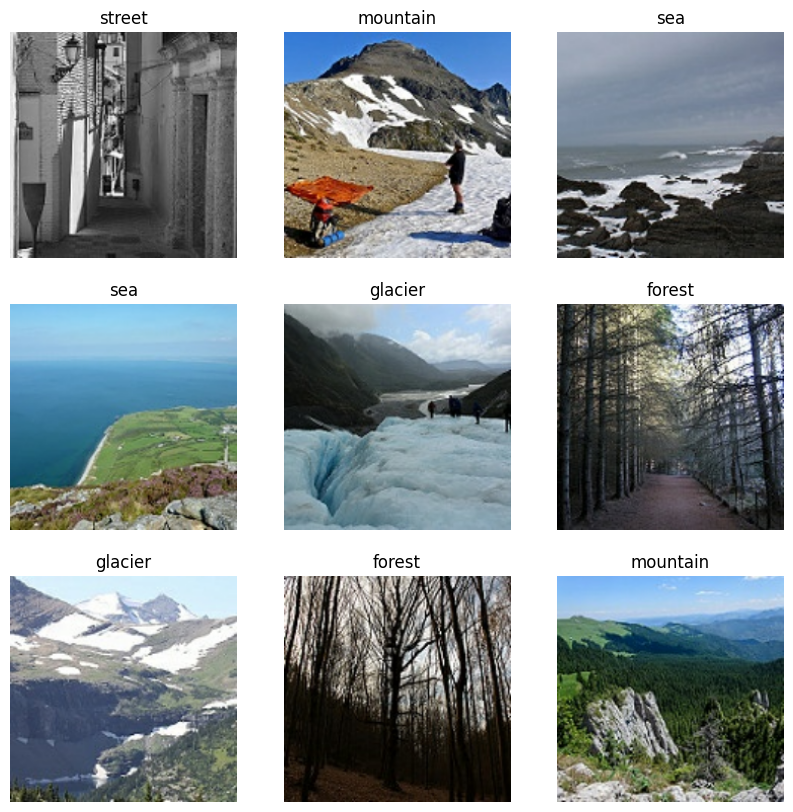

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Modelo con capas densas

In [ ]:
EPOCHS= 20

model_dense = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])
# Compilación
model_dense.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamiento
history = model_dense.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.2523 - loss: 16.6435 - val_accuracy: 0.3663 - val_loss: 1.5341
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.2987 - loss: 1.6106 - val_accuracy: 0.3520 - val_loss: 1.5255
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.2986 - loss: 1.5894 - val_accuracy: 0.3387 - val_loss: 1.5783
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3201 - loss: 1.5742 - val_accuracy: 0.2900 - val_loss: 1.6276
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.3154 - loss: 1.6120 - val_accuracy: 0.3267 - val_loss: 1.6298
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2990 - loss: 1.6402 - val_accuracy: 0.2933 - val_loss: 1.6185
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2906 - loss: 1.6401 - val_accuracy: 0.3073 - val_loss: 1.6234
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3111 - loss: 1.6115 -

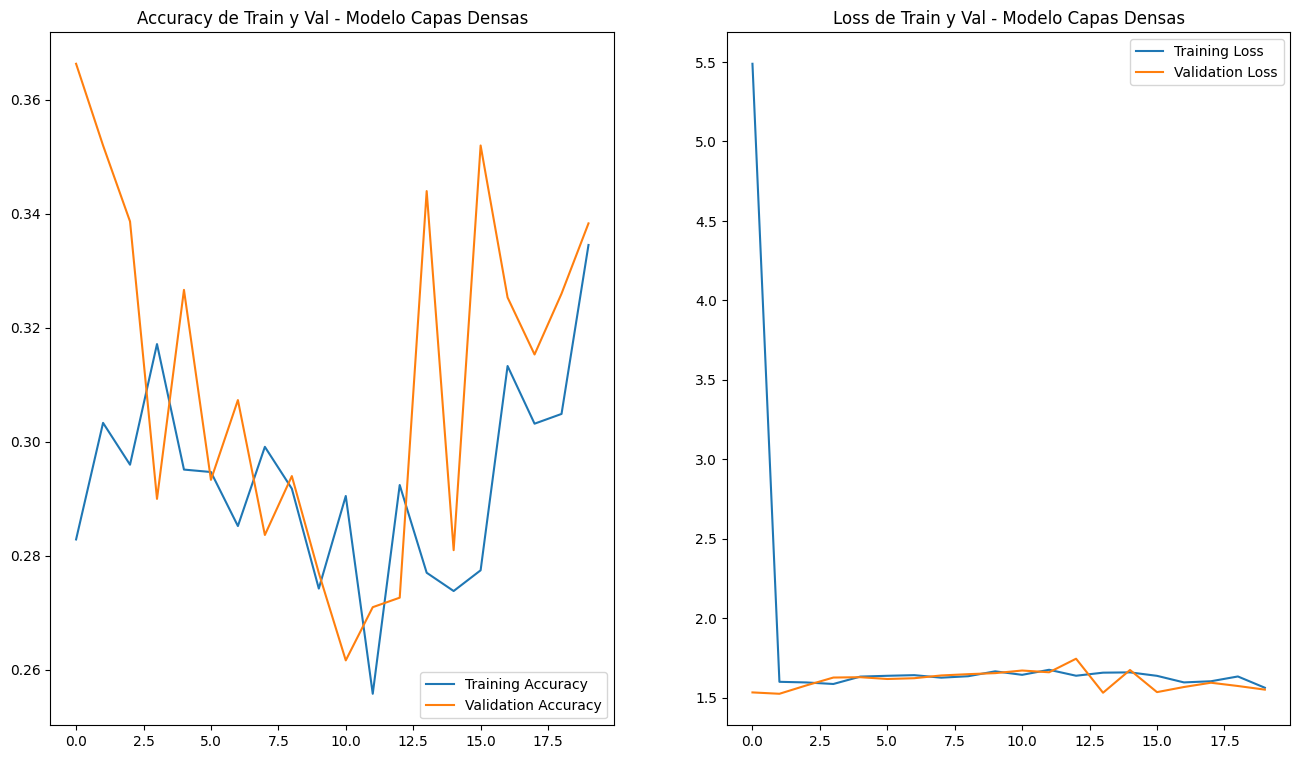

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy de Train y Val - Modelo Capas Densas')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss de Train y Val - Modelo Capas Densas')
plt.show()

Podemos observar oscilaciones bruscas en la gráfica de Accuracy. Esto se debe a que al no usar capas convolucionales, el modelo está aprendiendo con mayor dificultad, y esto hace que cada epoch varíe drásticamente dependiendo del batch.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


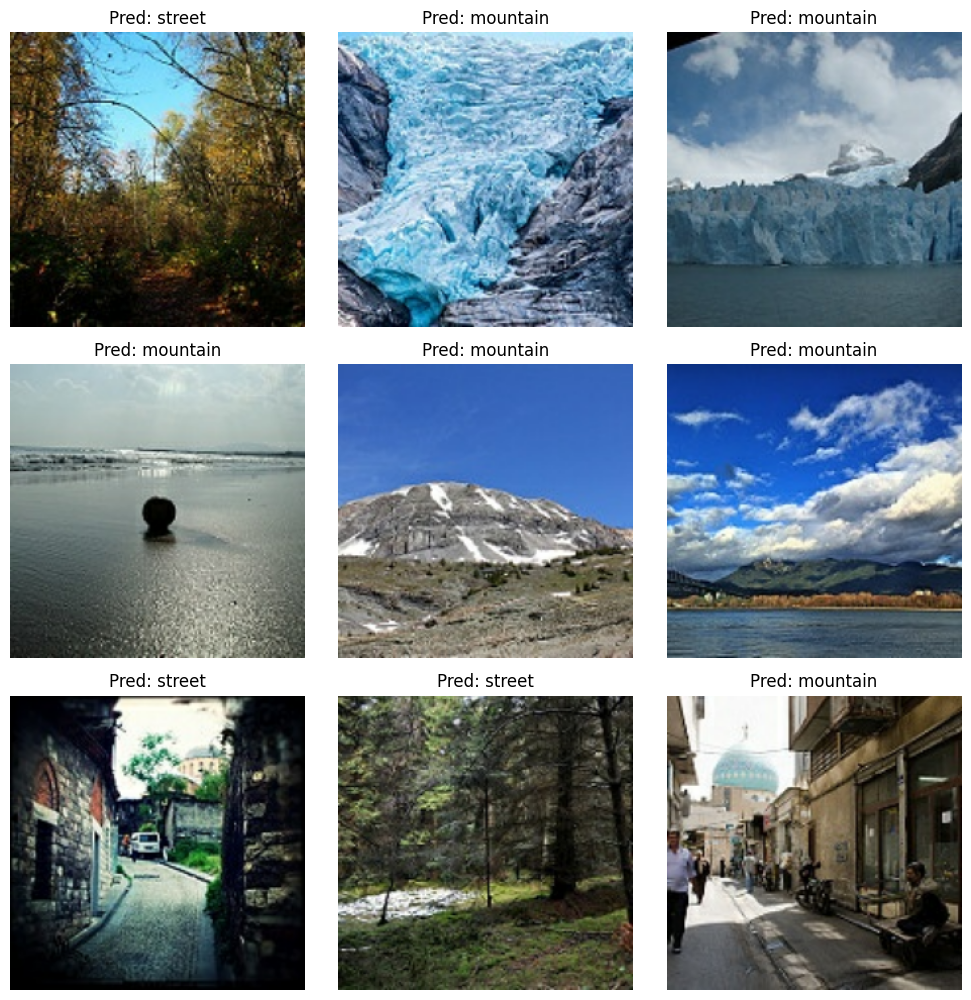

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_dense.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))  # mostrar imagen
    plt.title(f"Pred: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

Los modelos que se componen únicamente de capas densas se encuentran ya de por sí limitados al trabajar con datos de imágenes. Esto se debe a que la imagen se aplana y pierde los datos espaciales.

Nuestra primera red de capas densas, que era muy simple `(Flatten → Dense(16, relu) → Dense(6, softmax))` obtenía una Accuracy de apenas `0.18`, lo cual apenas supera al azar (100%/6 = 16.6%).

Intentamos sumar capas ocultas, neuronas y dropouts para evitar el overfitting, lo cual mejoró el Accuracy hasta `0.33`. De todos modos, esto sigue siendo un Accuracy relativamente bajo; nuestra conclusión es que un modelo de capas densas no es una solución efectiva para este tipo de problema.

Se podría utilizar este tipo de red como un modelo base, que nos ayude a determinar el rendimiento minimo que deberían tener nuestras redes convolucionales.

# Modelo con capas convolucionales y densas

In [ ]:
# EPOCHS= 20

# # Definición del modelo
# model = Sequential([
#     Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     Conv2D(32, (3, 3)),
#     Activation("relu"),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3)),
#     Activation("relu"),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(16, activation="relu"),
#     Dense(6, activation="softmax")
# ])

# # Compilación
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # Entrenamiento
# history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

# # Evaluación
# test_loss, test_acc = model.evaluate(test_ds)
# print(f"Precisión en test: {test_acc:.4f}")

In [ ]:
# # Grafica la precisión y pérdida de entrenamiento y validación
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)

# plt.figure(figsize=(12, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# # Obtener las clases en orden desde train_ds (asumiendo que es un image_dataset_from_directory)
# class_names = train_ds.class_names

# # Obtener 10 imágenes del test
# images = []
# for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
#     images = img_batch.numpy()[:30]  # Tomamos las primeras 10
#     break

# # Predecir
# preds = model.predict(images)
# predicted_labels = np.argmax(preds, axis=1)

# # Mostrar
# plt.figure(figsize=(20, 50))
# for i in range(30):
#     plt.subplot(10, 3, i+1)
#     plt.imshow(images[i].astype("uint8"))  # mostrar imagen
#     plt.title(f"Pred: {class_names[predicted_labels[i]]}")
#     plt.axis("off")
# plt.tight_layout()
# plt.show()

In [ ]:
EPOCHS= 20

# Definición del modelo
model_conv = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    RandomFlip("horizontal"),
    RandomFlip("vertical"),
    RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    RandomContrast(0.2),
    Conv2D(8, (3, 3)),
    Activation("relu"),
    Conv2D(16, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    Activation("relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation="relu"),
    Dense(6, activation="softmax")
])

# Compilación
model_conv.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamiento
hist_conv = model_conv.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.3518 - loss: 1.5408 - val_accuracy: 0.5730 - val_loss: 1.0148
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5674 - loss: 1.0506 - val_accuracy: 0.6213 - val_loss: 0.8810
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.6208 - loss: 0.9179 - val_accuracy: 0.6813 - val_loss: 0.8154
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6704 - loss: 0.8417 - val_accuracy: 0.7273 - val_loss: 0.7379
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.7125 - loss: 0.7384 - val_accuracy: 0.7710 - val_loss: 0.6278
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.7535 - loss: 0.6721 - val_accuracy: 0.7743 - val_loss: 0.6156
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.7598 - loss: 0.6495 - val_accuracy: 0.7853 - val_loss: 0.5952
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.7796 - loss: 0.6109 - val_accurac

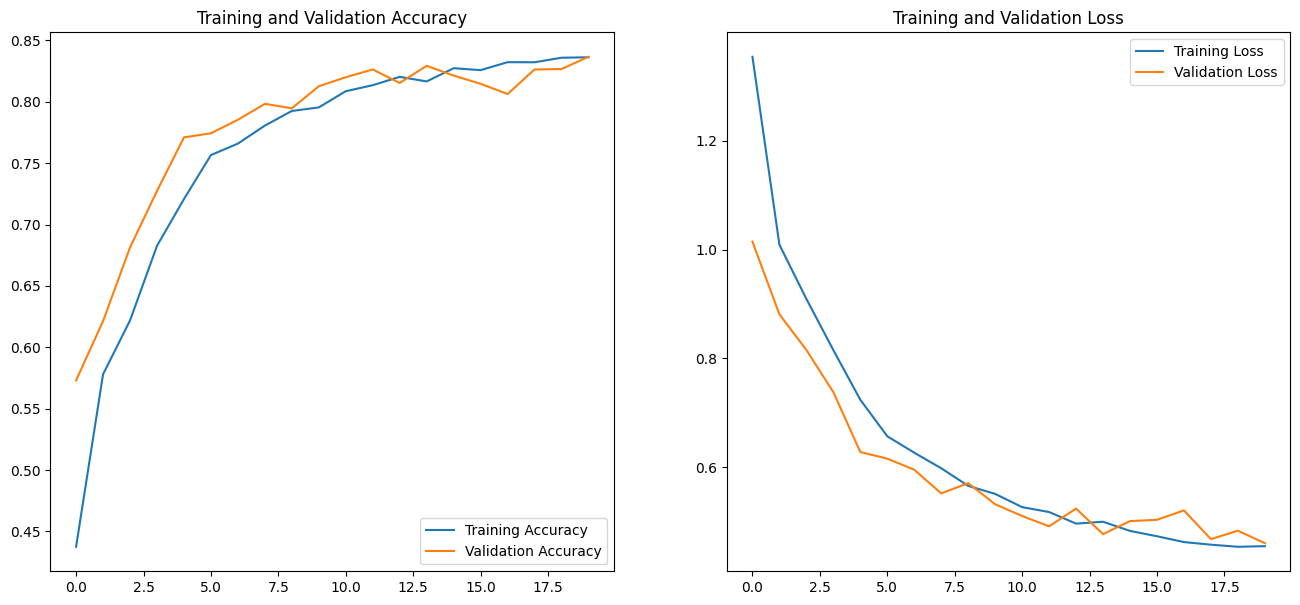

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = hist_conv.history['accuracy']
val_acc = hist_conv.history['val_accuracy']

loss = hist_conv.history['loss']
val_loss = hist_conv.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

El modelo converge bien y mantiene una brecha pequeña entre el entrenamiento y la validación, lo que indica buena capacidad de generalización. No se observa overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


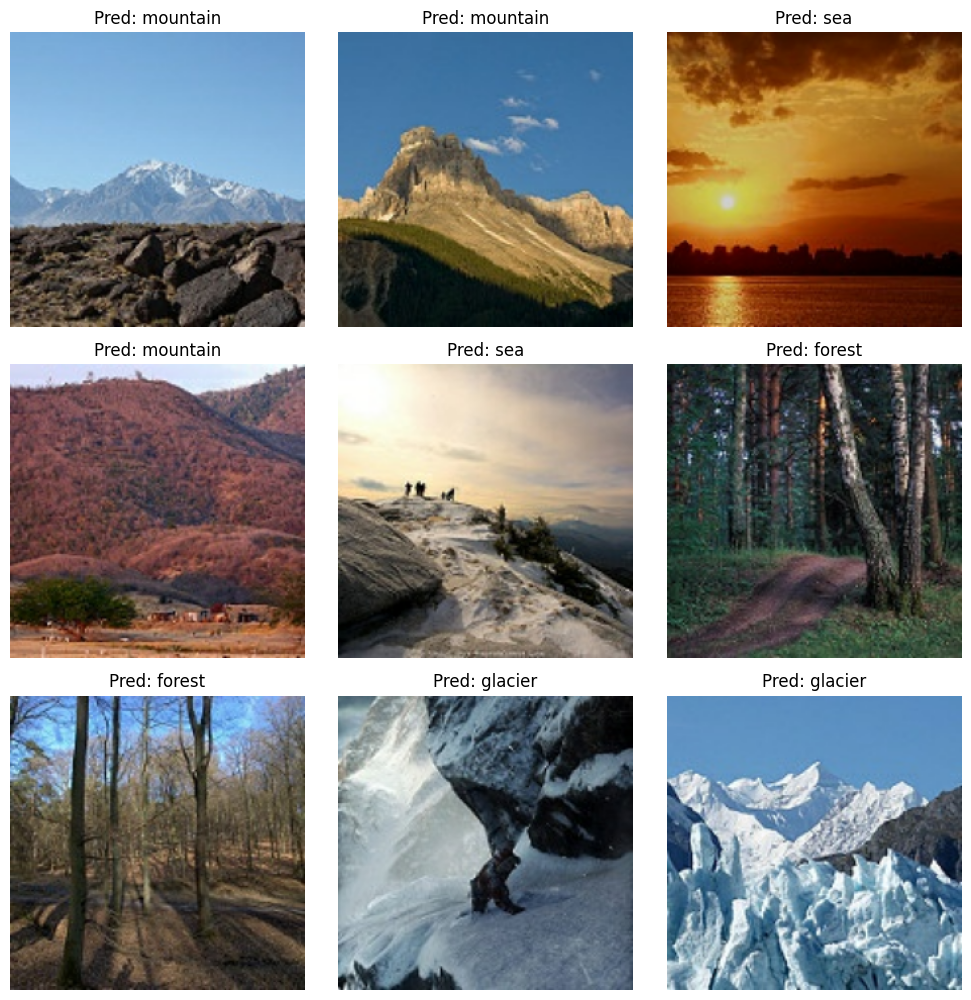

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción
preds = model_conv.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))  # mostrar imagen
    plt.title(f"Pred: {class_names[predicted_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Conclusiones

El uso de capas convolucionales le permite al modelo aprender patrones visuales significativos y generalizar correctamente. Este modelo es claramente superior al modelo de capas densas, con una accuracy de ~83%

Además de la combinación base de capas convolucionales, capas ReLu y Maxpooling, se incorporó *Normalización* y *Data Augmentation* por medio de los RandomFlip, RandomTranslation y RandomContrast, los cuales ayudan al modelo a generalizar mejor.

# Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning)

In [ ]:
EPOCHS = 20

# Modelo base ya entrenado
base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # Congelamos para transfer learning

# Definición del modelo
model_transfer = Sequential([
    Rescaling(1./255 , input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(6, activation="softmax")
])

#Compilación
model_transfer.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Entrenamiento
history = model_transfer.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.8462 - loss: 0.4407 - val_accuracy: 0.9127 - val_loss: 0.2329
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.9158 - loss: 0.2189 - val_accuracy: 0.9077 - val_loss: 0.2424
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9325 - loss: 0.1804 - val_accuracy: 0.9047 - val_loss: 0.2458
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9417 - loss: 0.1529 - val_accuracy: 0.9067 - val_loss: 0.2459
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9482 - loss: 0.1358 - val_accuracy: 0.9100 - val_loss: 0.2494
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9592 - loss: 0.1128 - val_accuracy: 0.9070 - val_loss: 0.2616
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9636 - loss: 0.0969 - val_accuracy: 0.8913 - val_loss: 0.3294
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 1

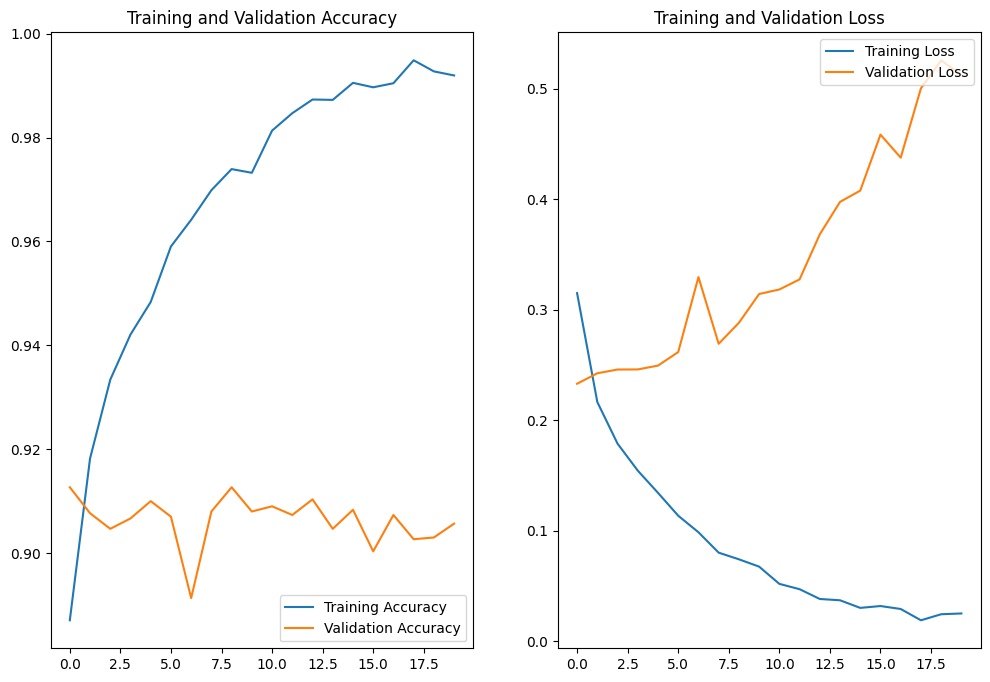

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Pareciera observarse una gran diferencia entre la curva de Train y Validation, lo que podría indicar overfitting, sin embargo la direfencia es de unos 9 puntos, entre 90% y 99%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


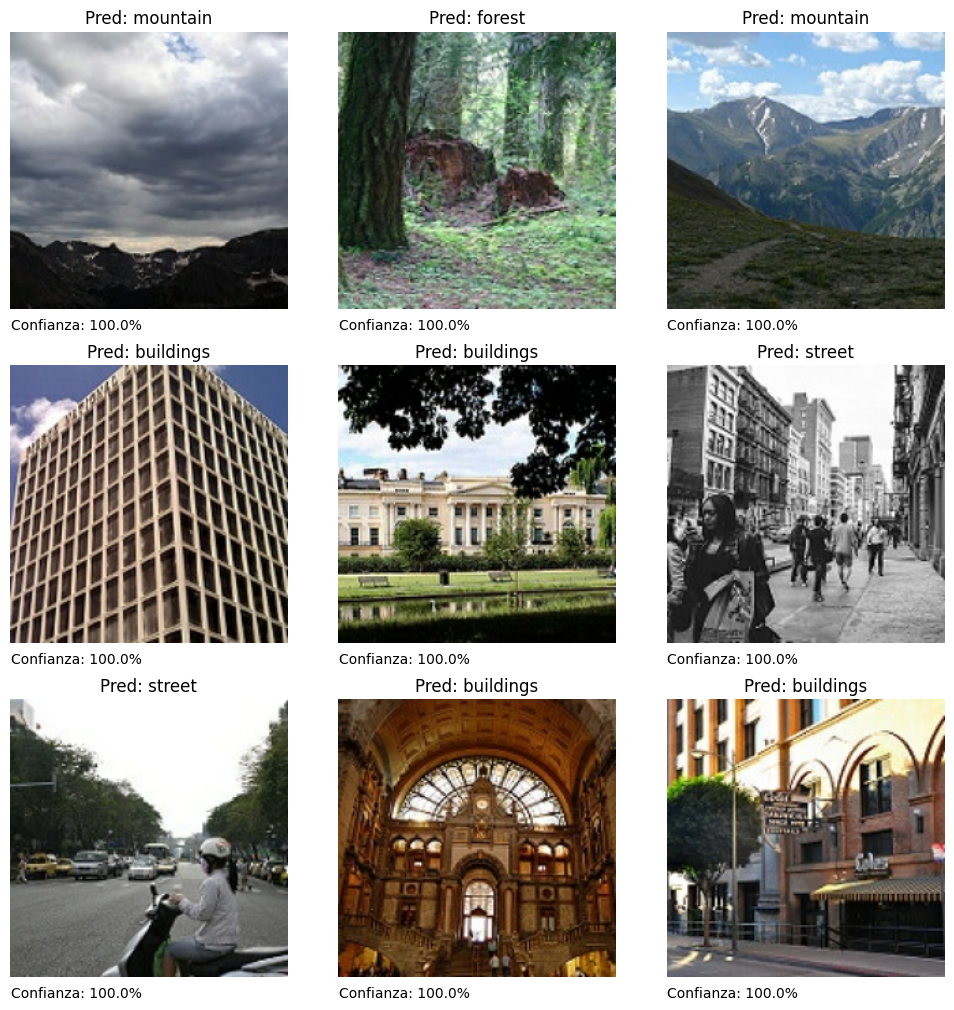

In [ ]:
# Obtener 9 imágenes del test
images = []
for img_batch, _ in test_ds.take(1):  # Tomamos un batch del test_ds
    images = img_batch.numpy()[:9]  # Tomamos las primeras 9
    break

# Predicción

preds = model_transfer.predict(images)
predicted_labels = np.argmax(preds, axis=1)

# Mostrar
plt.figure(figsize=(10, 30))
for i in range(9):
    plt.subplot(9, 3, i+1)
    plt.imshow(images[i].astype("uint8"))

    class_index = predicted_labels[i]
    class_label = class_names[class_index]
    confidence = preds[i][class_index] * 100  # Calculamos dentro del loop
    plt.title(f"Pred: {class_label}", fontsize=12)
    plt.text(0, 240, f"Confianza: {confidence:.1f}%", fontsize=10, color='black')
    plt.axis("off")
plt.tight_layout()
plt.show()



# Modelo que incluya bloques residuales identidad

In [ ]:
from tensorflow.keras.layers import Add, ReLU, BatchNormalization

def identity_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x


def res_net(input_shape, num_classes):
  input_layer = Input(shape=input_shape)
  x = Conv2D(32, (3, 3), padding='same')(input_layer)
  x = ReLU()(x)

  x = identity_block(x, 32)
  x = MaxPooling2D((2, 2))(x)

  x = identity_block(x, 32)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  output_layer = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

model = res_net((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
EPOCHS = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 75s 144ms/step - accuracy: 0.3755 - loss: 161.4529 - val_accuracy: 0.3780 - val_loss: 1.4507
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 58s 132ms/step - accuracy: 0.4611 - loss: 1.2687 - val_accuracy: 0.5807 - val_loss: 1.0769
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.6139 - loss: 0.9680 - val_accuracy: 0.5240 - val_loss: 1.2739
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - accuracy: 0.6754 - loss: 0.8312 - val_accuracy: 0.6333 - val_loss: 1.1006
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.7476 - loss: 0.6620 - val_accuracy: 0.6410 - val_loss: 1.1982
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 126ms/step - accuracy: 0.7520 - loss: 0.6708 - val_accuracy: 0.6533 - val_loss: 1.2985
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.8253 - loss: 0.4778 - val_accuracy: 0.6633 - val_loss: 1.3045
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.8513 - loss:

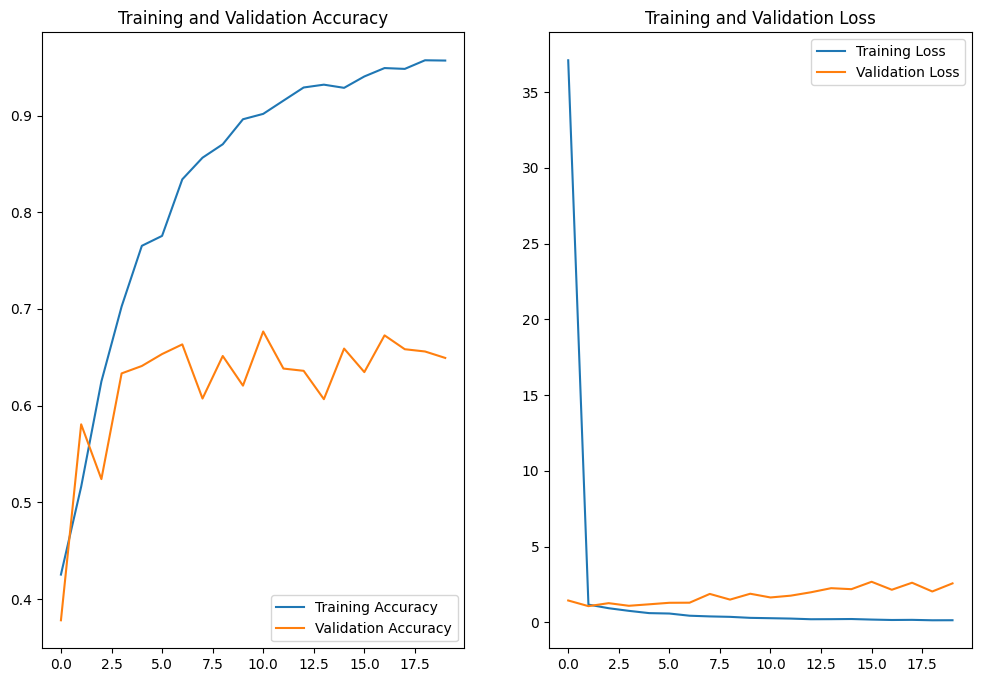

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()